In [ ]:
# Installation dial les dépendances li khassna
!pip install tensorflow keras numpy

In [ ]:
import re
import numpy as np
import pickle # Bach n7effdou l'tokenizer

# Keras/TensorFlow Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
file_name = '1661-0 (4).txt'

try:
    # 2. Read the file
    # We use 'encoding='utf-8'' to make sure all characters are read correctly
    with open(file_name, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    print(f"✅ Successfully read '{file_name}'!")

except FileNotFoundError:
    print(f"❌ ERROR: File not found: '{file_name}'.")
    print("Please upload the file to Colab and run this cell again.")
    raw_text = "" # Set to empty string if error

✅ Successfully read '1661-0 (4).txt'!


In [ ]:
# 3. Define the cleaning function
def clean_text(text):
    # Define the start and end markers for the main content
    start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***"
    end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***"

    try:
        # Extract only the text between the markers
        start_index = text.index(start_marker) + len(start_marker)
        end_index = text.index(end_marker)
        text = text[start_index:end_index]
    except ValueError:
        # If markers aren't found, just clean the whole text (as a fallback)
        print("Note: Gutenberg start/end markers not found. Cleaning the entire file.")

    # Remove all non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Replace multiple spaces (like newlines) with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# 4. Clean the text (only if the file was read successfully)
if raw_text:
    # We create the 'cleaned_text' variable that we will use in the next steps
    cleaned_text = clean_text(raw_text)
    print("\n✅ Step 2 Complete: Text is cleaned and ready!")
    print("\n--- First 500 characters of cleaned text ---")
    print(cleaned_text[:500])
else:
    print("\n❌ Cleaning skipped because the file was not read.")


✅ Step 2 Complete: Text is cleaned and ready!

--- First 500 characters of cleaned text ---
produced by an anonymous project gutenberg volunteer and jose menendez cover the adventures of sherlock holmes by arthur conan doyle contents i a scandal in bohemia ii the redheaded league iii a case of identity iv the boscombe valley mystery v the five orange pips vi the man with the twisted lip vii the adventure of the blue carbuncle viii the adventure of the speckled band ix the adventure of the engineers thumb x the adventure of the noble bachelor xi the adventure of the beryl coronet xii th


In [ ]:
# --- STEP 3 (NEW): Tokenization and FIXED Sequence Preparation ---
# This version is memory-efficient and avoids crashing Colab RAM.

# 1. Initialize and Fit the Tokenizer (Same as before)
tokenizer = Tokenizer()
tokenizer.fit_on_texts([cleaned_text])
total_words = len(tokenizer.word_index) + 1

print(f"Total unique words (Vocabulary Size): {total_words}")

# 2. Convert all text to a single list of tokens (numbers)
# Instead of many small lists, we make one big list of the entire book
token_list = tokenizer.texts_to_sequences([cleaned_text])[0]
print(f"Total tokens in the entire text: {len(token_list)}")

# 3. Define a FIXED sequence length (The most important change!)
# We will predict the next word based on the 50 previous words.
# You can change this number (e.g., 20, 50, 100)
sequence_length = 50

# 4. Create fixed-size input sequences (X) and outputs (y)
X_sequences = [] # This will hold our inputs
y_labels = []    # This will hold our outputs

# Iterate through the token list with a sliding window
for i in range(sequence_length, len(token_list)):
    # Input (X): The sequence of 50 words
    # Example: tokens from index [i-50] to [i]
    X_sequences.append(token_list[i - sequence_length : i])

    # Output (y): The single word that comes *after* the sequence
    # Example: token at index [i]
    y_labels.append(token_list[i])

print(f"Total sequences created: {len(X_sequences)}")

# 5. Convert lists to NumPy arrays (This is much smaller now!)
# We don't need padding because all sequences are already the same length (50)
Xs = np.array(X_sequences)

# 6. Convert labels to One-Hot Encoding
#Ys = to_categorical(y_labels, num_classes=total_words)
Ys = np.array(y_labels)

print("\n✅ Step 3 Complete (Memory Efficient): Data is ready!")
print(f"Shape of Inputs (Xs): {Xs.shape}") # Should be (num_sequences, 50)
print(f"Shape of Outputs (Ys): {Ys.shape}") # Should be (num_sequences, total_words)

Total unique words (Vocabulary Size): 8331
Total tokens in the entire text: 104402
Total sequences created: 104352

✅ Step 3 Complete (Memory Efficient): Data is ready!
Shape of Inputs (Xs): (104352, 50)
Shape of Outputs (Ys): (104352,)


In [ ]:
# --- STEP 4: Build the Model Architecture (Bi-LSTM) ---

# We get the input dimensions from our new 'Xs' in Step 3
# Xs.shape[1] is the length of our input sequences (which is 50)
input_len = Xs.shape[1]
# total_words is our vocabulary size (e.g., 8225)

# 1. Initialize the Sequential model
model = Sequential()

# 2. Add the Embedding layer
# '100' is the dimension of the embedding vector for each word.
# 'input_length' must match our new sequence length (50)
model.add(Embedding(total_words, 100, input_length=input_len))

# 3. Add the Bidirectional LSTM layer (YOUR CUSTOMIZATION!)
# '150' is the number of neurons (units).
model.add(Bidirectional(LSTM(150)))

# 4. Add a Dropout layer
# This helps prevent overfitting by randomly "turning off" 20% of neurons.
model.add(Dropout(0.2))

# 5. Add the Final Output layer (Dense layer)
# The number of neurons must equal 'total_words' (our vocabulary size).
# 'softmax' activation converts the output into a probability distribution.
model.add(Dense(total_words, activation='softmax'))

# 6. Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use this loss for multi-class classification
    optimizer=Adam(learning_rate=0.001), # Adam is a very effective optimizer
    metrics=['accuracy']                 # We want to monitor the 'accuracy'
)

# 7. Print the model summary
print("\n✅ Step 4 Complete: Model Architecture is Built!")
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



✅ Step 4 Complete: Model Architecture is Built!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# --- STEP 5: Train the Model ---

# NOTE: Running this cell will automatically build the model, resolving the "unbuilt" status.
print("\nStarting Model Training...")

history = model.fit(
    Xs,
    Ys,
    epochs=20,     # Number of training epochs (adjust as needed)
    batch_size=128, # Batch size (adjust as needed)
    verbose=1       # Display progress
)

print("\n✅ Training completed!")


Starting Model Training...
Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.0564 - loss: 6.7282
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.0889 - loss: 5.8821
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1227 - loss: 5.4633
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1369 - loss: 5.1758
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1518 - loss: 4.9035
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.1647 - loss: 4.6300
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1816 - loss: 4.3349
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2097 - loss: 4.0268
Epoch 9/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.2460 - loss: 3.7540
Epoch 10/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.2843 - loss: 3.4786
Epoch 11/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3164 - loss: 3.2514
Ep


--- FINAL TRAINING METRICS ---
Final Accuracy: 0.5037
Final Loss: 2.1314


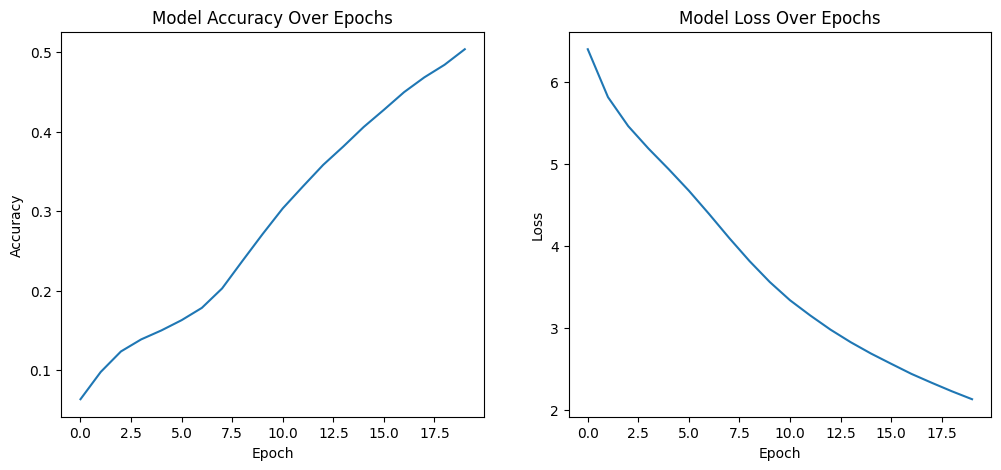

In [ ]:
# --- STEP 6: Display Final Metrics and Plot History ---

# 1. Display Final Metrics
final_accuracy = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]

print("\n--- FINAL TRAINING METRICS ---")
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Loss: {final_loss:.4f}")

# 2. Plotting the training history (requires matplotlib)
# NOTE: Make sure you have 'import matplotlib.pyplot as plt' at the top of your script

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# # Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()


In [ ]:
# --- STEP 5 (Continuation): Train the Model for 20 more Epochs ---

print("\nStarting Model Training (Continuing from Epoch 20 to 40)...")

# On utilise un nouvel objet history pour stocker les résultats de cette session
history_continuation = model.fit(
    Xs,
    Ys,
    epochs=40,        # Le nombre total d'epochs souhaité
    initial_epoch=20, # On commence l'entraînement à partir de l'epoch 20
    batch_size=128,
    verbose=1
)

# NOTE IMPORTANTE: Pour que les graphiques de l'étape 6 soient corrects,
# vous devez fusionner les résultats de l'ancien 'history' avec le nouveau 'history_continuation'.
# Si vous avez stocké le premier résultat dans 'history', utilisez ce code :

# history.history['accuracy'].extend(history_continuation.history['accuracy'])
# history.history['loss'].extend(history_continuation.history['loss'])

print("\n✅ Training continuation completed!")



Starting Model Training (Continuing from Epoch 20 to 40)...
Epoch 21/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5370 - loss: 1.9694
Epoch 22/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5583 - loss: 1.8668
Epoch 23/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5715 - loss: 1.8051
Epoch 24/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5863 - loss: 1.7260
Epoch 25/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5995 - loss: 1.6529
Epoch 26/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6151 - loss: 1.5911
Epoch 27/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6242 - loss: 1.5317
Epoch 28/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6388 - loss: 1.4675
Epoch 29/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6482 - loss: 1.4146
Epoch 30/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6590 - loss: 1.3598
Epoch 31/40
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms

In [ ]:
print("\n starting Model Training (continuing from 40 to 60)...")

third_model_continuation = model.fit(
    Xs,
    Ys,
    epochs=60,
    initial_epoch=40,
    batch_size=128,
    verbose=1
)
print("\training contunauation complete")


 starting Model Training (continuing from 40 to 60)...
Epoch 41/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7513 - loss: 0.9405
Epoch 42/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7554 - loss: 0.9162
Epoch 43/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7627 - loss: 0.8865
Epoch 44/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7676 - loss: 0.8638
Epoch 45/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7713 - loss: 0.8427
Epoch 46/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7774 - loss: 0.8190
Epoch 47/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7801 - loss: 0.7971
Epoch 48/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7883 - loss: 0.7731
Epoch 49/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7910 - loss: 0.7606
Epoch 50/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7962 - loss: 0.7366
Epoch 51/60
816/816 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step

In [ ]:
# Zid had l'importation f l'awal dyal l'notebook dyalek
# from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len):
    """
    Generates text based on a starting phrase (seed_text).
    """
    output_text = seed_text

    for _ in range(next_words):
        # 1. Tokenize the current seed text
        cleaned_seed = seed_text.lower().strip()
        token_list = tokenizer.texts_to_sequences([cleaned_seed])[0]

        # 2. Pad the sequence to the fixed length (50)
        # We use 'pre' padding to add zeros at the beginning,
        # so the last 50 words are the ones the model sees.
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')[0]

        # 3. Reshape the list to a numpy array with shape (1, 50) for the model
        token_list = np.array(token_list).reshape(1, max_sequence_len)

        # 4. Predict the next word's probabilities
        predicted_probabilities = model.predict(token_list, verbose=0)[0]

        # 5. Get the index of the word with the highest probability (the predicted word)
        predicted_word_index = np.argmax(predicted_probabilities)

        # 6. Convert the index back to a word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break

        # 7. Append the new word to the sequence for the next prediction
        seed_text += " " + output_word
        output_text += " " + output_word

    return output_text

# --- EXAMPLE USAGE ---

# Make sure you have 'sequence_length' defined (it should be 50)
sequence_length = 50
seed = "it is a capital mistake to theorize"
num_words_to_generate = 100

generated_result = generate_text(
    seed_text=seed,
    next_words=num_words_to_generate,
    model=model,
    tokenizer=tokenizer,
    max_sequence_len=sequence_length
)

print("\n--- GENERATED TEXT ---")
print(generated_result)



--- GENERATED TEXT ---
it is a capital mistake to theorize be up and made a cry of red and with a red part of his face he could hardly have been he made his medical peculiar round to opium me that he had gone with her head for an indian weather i had no doubt that he had only been in a single man who could do he he looked with me once at the time that the inspector had been an excellent air of an instant holmes was a man who had noticed his signature in his hand and his eyes have been shattered by his face and his


In [ ]:
# --- ÉTAPE 8 : Sauvegarder le Modèle ---

# Définir le nom du fichier de sauvegarde (format Keras natif)
model_filename_new = 'sherlock_bilstm_model.keras'

# Sauvegarde du modèle b l'format jdid (.keras)
try:
    model.save(model_filename_new)
    print(f"✅ Modèle sauvegardé avec succès sous l'format .keras : {model_filename_new}")

except Exception as e:
    print(f"❌ Erreur lors de la sauvegarde : {e}")


✅ Modèle sauvegardé avec succès sous l'format .keras : sherlock_bilstm_model.keras
